- 이 자료는 핸즈온 머신러닝 책 & 코드와 고려대학교 강필성 교수님 강의를 공부한 내용입니다.

## SetUp

In [1]:
import os
import numpy as np

# 일관된 출력을 위해 유사난수 초기화
np.random.seed(42)

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
sn.set()
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
# matplotlib.rc('font', family='AppleGothic')  # MacOS
matplotlib.rc('font', family='Malgun Gothic')  # Windows
plt.rcParams['axes.unicode_minus'] = False

In [2]:
# LabelEncoder 버그로 인해 생기는 DeprecationWarning 막기
# https://github.com/scikit-learn/scikit-learn/pull/9816
# https://stackoverflow.com/questions/49545947/sklearn-deprecationwarning-truth-value-of-an-array
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

## 7.2 배깅과 페이스팅 (Bagging and Pasting)

'7.1 - 투표기반 분류기'에서는 여러개의 머신러닝 알고리즘을 이용해 분류기를 만들어 앙상블 학습을 했다. 이번에 알아볼 또 다른 방법으로는 하나의 알고리즘을 사용하지만 학습 데이터셋을 랜덤하게 추출하여 모델(분류기)을 각각 다르게 학습시키는 방법이다. 

이렇게, 학습 데이터셋에서 랜덤하게 추출할 때, 중복을 허용하는 방식을 **배깅**(bagging)이라고 한다. 배깅(bagging)은 **bootstrap aggregating**의 줄임말이며 통계학에서는 중복을 허용한 리샘플링(resampling)을 **부트스트래핑**(bootstraping)이라고 한다. (aggregate는 집계하다)이와 반대로 중복을 허용하지 않는 샘플링 방식을 **페이스팅**(pasting)이라고 한다.

![](./img/bagging.png)

위의 그림에서 각 모델이 학습된 후에 새로운 데이터에 대해서는 '7.1 - 투표기반 분류기'와 동일하게 분류(classification)일 때는 **최빈값(mode)** 즉, 가장 많은 예측 클래스로 앙상블이 예측하며, 회귀(regression)일 경우에는 각 분류기의 예측값의 평균을 계산하여 평균값을 예측값으로 한다.

각 모델은 전체 학습 데이터셋으로 학습시킨 것보다 편향되어 있지만, 앙상블을 통해 편향(bias)과 분산(variance)이 감소한다. 일반적으로 앙상블 학습은 전체 학습 데이터셋을 이용해 하나의 모델을 학습시킬 때와 비교해서 편향은 비슷하지만 분산은 줄어든다고 한다. 

![](./img/WhyBagging.PNG)

- Bagging이 잘되는 원리는 데이터가 갖는 분포를 좋은쪽으로 왜곡시키기 때문
- Original Dataset만 사용햇을 경우 epsilon(noise)에 종속적인 모델을 만들지만 Bagging은 이러한 것을 방지

![](./img/WhyBagging2.PNG)

- Bagging은 K-fold와 유사한 기능을 가질 수 있음(더 우수한)
- 전체 데이터가 역할을 바꿔가며 학습과 검증 + 노이즈 왜곡
    - k-fold와 유사한 기능을 가지면서 좋은쪽으로 왜곡도 시켜주니 우수함

### 7.2.1 사이킷런의 배깅과 페이스팅

Scikit-Learn은 배깅과 페이스팅을 간편하게 사용할 수 있도록 분류일 경우에는 [`BaggingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html)를 회귀일 경우 [`BaggingRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn.ensemble.BaggingRegressor)를 제공한다. 

아래의 예제는 '7.1 - 투표기반 분류기'에서 다룬 `moons` 데이터셋을 `BaggingClassifier`를 이용해 500개의 의사결정나무(decision tree)모델을 만들어 배깅을 적용한 앙상블 학습을 한 예제이다.

#### `moons` 데이터셋 로드하기

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [4]:
X_train.shape

(375, 2)

#### 단 하나의 Decision Tree를 사용할 경우

먼저 배깅을 이용한 앙상블 학습이 얼마나 더 성능이 좋은지 비교하기 위해, 단 하나의 의사결정나무 모델을 이용해 `moons` 데이터셋에 적용해 보자.

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


#### Bagging을 이용한 앙상블 학습

이번에는 `BaggingClassifier`를 이용해 500개의 의사결정나무 모델을 만들어 보자. `BaggingClassifier`는 사용하는 알고리즘 모델(분류기)가 각 예측 클래스의 확률을 추정할 수 있으면, 직접 투표(hard voting)대신 간접 투표(soft voting) 방식을 사용한다.

In [6]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

"""
n_estimators: 분류기 개수
max_samples: 무작위 데이터 샘플 개수(학습용)
bootstrap: resampling 여부(페이스팅을 사용하려면 False)
n_jobs: CPU 코어 개수(-1이면 모든 코어 사용)
"""
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)


bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


- 참고로 앙상블 + 트리는 Random Forest와는 다른 것

위에서 확인할 수 있듯이 배깅을 이용한 방법이 정확도가 5%나 더 좋게 나온것을 확인할 수 있다. 아래의 그림은 하나의 의사결정나무에 대한 결정 경계(decision boundary)와 배깅을 이용한 앙상블 트리에 대한 결정 경계를 비교한 그래프이다. 그래프에서도 확인할 수 있듯이 앙상블 학습이 일반화(generalization)이 더 잘 된것을 알 수 있다.

In [7]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

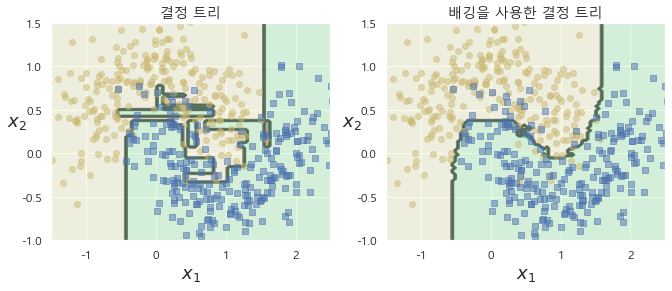

In [8]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("결정 트리", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("배깅을 사용한 결정 트리", fontsize=14)
plt.show()

### 7.2.2 OOB(Out-of-Bag) 평가

배깅은 중복을 허용하는 리샘플링(resampling) 즉, 부트스트래핑(bootstraping) 방식이기 때문에 전체 학습 데이터셋에서 어떠한 데이터 샘플은 여러번 샘플링 되고, 또 어떠한 샘플은 전혀 샘플링 되지 않을 수가 있다. 평균적으로 학습 단계에서 전체 학습 데이터셋 중 63% 정도만 샘플링 되며(자세한 내용은 [여기](https://tensorflow.blog/%EB%9E%9C%EB%8D%A4-%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8%EC%97%90%EC%84%9C-%EB%8D%B0%EC%9D%B4%ED%84%B0%EA%B0%80-%EB%88%84%EB%9D%BD%EB%90%A0-%ED%99%95%EB%A5%A0/) 참고), 샘플링 되지 않은 나머지 37% 데이터 샘플들을 **oob(out-of-bag) 샘플**이라고 한다.

앙상블(배깅) 모델의 학습 단계에서는 oob 샘플이 사용되지 않기 때문에, 이러한 oob 샘플을 검증셋(validation set)이나 교차검증(cross validation)에 사용할 수 있다. 

Scikit-Learn에서는 `BaggingClassifier`의 인자인 `oob_score=True`로 설정하면 학습이 끝난 후 자동으로 oob 평가를 할 수 있다. 

아래의 예제는 7.2.1 에서 `moons` 데이터셋을 `BaggingClassifier`를 적용한 후 oob 평가를 해준 것이다.

In [9]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)

print('oob score :', bag_clf.oob_score_)

oob score : 0.8986666666666666


아래의 코드와 같이 oob 샘플에 대한 결정 함수(decision function) 값도 확인할 수 있다.

In [10]:
bag_clf.oob_decision_function_[:5]

array([[0.32275132, 0.67724868],
       [0.34117647, 0.65882353],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ]])

## 7.3 Random Patches & Random Subspace

`BaggingClassifier`는 특성(feature) 샘플링 또한 `max_features`와 `bootstrap_features` 두 개의 인자를 통해 제공한다. 위의 두 인자를 이용해 각 모델은 랜덤하게 선택한 특성(feature)으로 학습하게 된다.

이러한 방법은 데이터의 특성이 많은 고차원의 데이터셋을 다룰 때 적절하다. 학습 데이터 셋의 특성 및 샘플링(bootstraping) 사용 유무에 따라 두 종류로 나눌 수 있다.

- **Random Patches method** : 특성 및 데이터 셋 샘플링(bootstraping) 모두 사용하는 방식 
- **Random Subspace method** : 특성만 샘플링하는 방식
    - `bootstrap=False` 이고, `bootstrap_features=True` 그리고 `max_features`는 1.0보다 작은 값

이러한 특성 샘플링은 더 다양한 모델을 만들며 편향은 늘어나지만 분산을 낮출 수 있다.